In [1]:
from lib.models.deepsdf import DeepSDF
import torch

class SDF:
    def __init__(
        self,
        ckpt_path: str = "/checkpoints/last.ckpt",
        obj_idx: int = 0,
        device: str = None,
    ):
        self.device = device
        if self.device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.model = DeepSDF.load_from_checkpoint(ckpt_path).eval().to(self.device)

        self.total_points = None
        obj_idx = torch.tensor(obj_idx).to(self.device)
        self.lat_vec = self.model.lat_vecs(obj_idx)[None]


    def predict(self, points, mask = None):
        if self.total_points is None:
            self.total_points = points.shape[0]
            self.lat_vec = self.lat_vec.expand((self.total_points, -1))

        if mask is not None:
            return self.model.predict((points[mask], self.lat_vec[mask])).squeeze()
        return self.model.predict((points, self.lat_vec)).squeeze()
    
# settings
ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"
sdf = SDF(ckpt_path=ckpt_path, obj_idx=34)


/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.1.2, which is newer than your current Lightning version: v2.1.0
/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


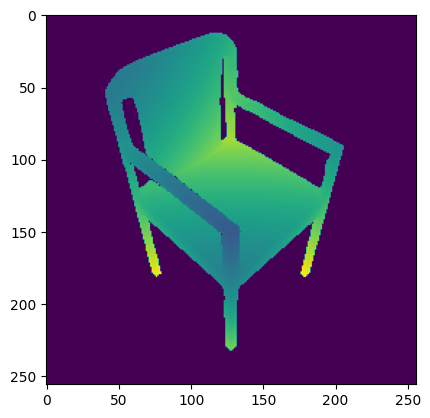

In [9]:
import torch
import numpy as np
import torch
import matplotlib.pyplot as plt
from lib.rendering.utils import normalize, R_azim_elev, dot

class Camera:
    def __init__(
        self,
        azim: float = 0.0,
        elev: float = 0.0,
        resolution: int = 256,
        dist: float = 1.0,
        focal_length: float = 1.0,
        device: str = "cuda",
    ):
        # rotation matrix
        R = R_azim_elev(azim=azim, elev=elev)

        # image plane
        xs = torch.linspace(0.5, -0.5, resolution)
        ys = torch.linspace(0.5, -0.5, resolution)
        zs = torch.full((resolution, resolution), -(dist), dtype=torch.float32)
        grid = torch.meshgrid(xs, ys)
        _image_plane = torch.stack([grid[0], grid[1], zs], axis=-1).view(-1, 3)
        self.image_plane = (R @ _image_plane.T).T.to(device)

        # camera point
        _camera = torch.tensor([0, 0, -(dist + focal_length)], dtype=torch.float32)
        self.camera_point = (R @ _camera).to(device)

        # rays
        self.rays = normalize(self.image_plane - self.camera_point)

        self.resolution = resolution

# initilial values
def sphere_tracing(
    points: torch.Tensor,
    rays: torch.Tensor,
    sdf: SDF,
    max_steps: int = 50,
    sd_step_scale: float = 0.6,
    surface_threshold: float = 1e-03,
    void_threshold: float = 2.0,
):
    total_points = points.shape[0]
    _points = points.clone().to(sdf.device)
    depth = torch.zeros((total_points,)).to(sdf.device)
    sd = torch.zeros((total_points,)).to(sdf.device)

    # masks
    mask = torch.full((total_points,), True, dtype=torch.bool).to(sdf.device)
    surface_mask = torch.full((total_points,), False, dtype=torch.bool).to(sdf.device)
    void_mask = torch.full((total_points,), False, dtype=torch.bool).to(sdf.device)

    # sphere tracing
    for _ in range(max_steps):
        next_points = points + depth[..., None] * rays
        with torch.no_grad():
            _sd = sdf.predict(points=next_points, mask=mask)

        _sd = _sd * sd_step_scale
        depth[mask] += _sd  # TODO this is a bottleneck
        sd[mask] = _sd  # TODO this is a bottleneck

        surface_idx = torch.where(sd < surface_threshold)
        mask[surface_idx] = False
        surface_mask[surface_idx] = True

        void_idx = torch.where(depth > void_threshold)
        mask[void_idx] = False
        void_mask[void_idx] = True

        _points[surface_idx] = next_points[surface_idx]

    return _points, surface_mask, void_mask


camera = Camera(azim=-45, elev=45, resolution=256, dist=1.2, device=sdf.device)
points, surface_mask, void_mask = sphere_tracing(
    points=camera.image_plane,
    rays=camera.rays,
    sdf=sdf,
)

def visualize_depth_map(points, camera, mask):
    distance_plane = torch.linalg.norm((points - camera.image_plane), dim=-1)
    distance_plane[~mask] = 0
    distance_plane = distance_plane.view(camera.resolution, camera.resolution)
    plt.imshow(distance_plane.detach().cpu().numpy().T)

visualize_depth_map(points, camera, surface_mask)

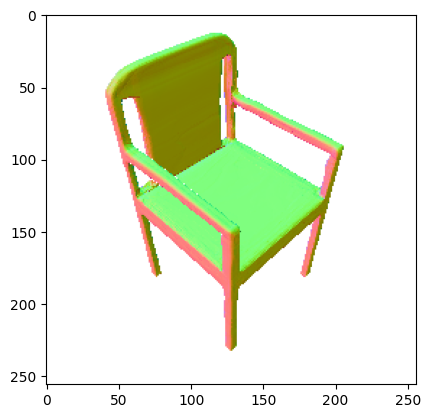

In [10]:
def normal(sdf: SDF, points: torch.Tensor, mask):
    xyz = torch.autograd.Variable(points, requires_grad=True)
    sd = sdf.predict(xyz, mask)
    loss = sd.sum()
    loss.backward()
    return normalize(xyz.grad)

normals = normal(sdf, points, surface_mask)


def visualize_normals(normals, camera, mask):
    normals_image = (normals + 1) / 2
    normals_image[~mask] = 1
    normals_image = normals_image.view(camera.resolution, camera.resolution, 3)
    plt.imshow(normals_image.permute(1, 0, 2).detach().cpu().numpy())

visualize_normals(normals, camera, surface_mask)

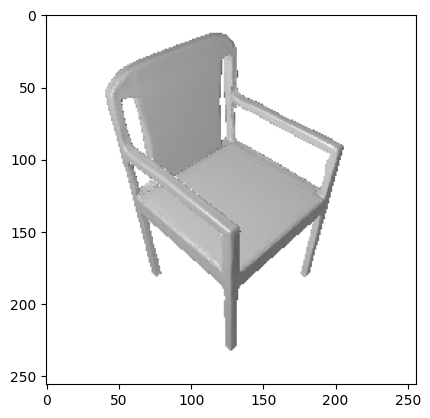

In [32]:
def visualize_mask(camera, mask):
    mask_image = mask.view(camera.resolution, camera.resolution).detach().cpu().numpy()
    plt.imshow(mask_image.T)

class PhongLight:
    def __init__(
        self,
        position: list[float] = [0, 0, 0],
        normal_step_eps=8e-03,
        ambient: list[float] = [0.5, 0.5, 0.5],
        diffuse: list[float] = [0.3, 0.3, 0.3],
        specular: list[float] = [0.3, 0.3, 0.3],
        shininess: float = 200.0,
        device: str = None,
    ):
        self.position = torch.tensor(position, dtype=torch.float32).to(device)
        self.ambient = torch.tensor(ambient, dtype=torch.float32).to(device)
        self.diffuse = torch.tensor(diffuse, dtype=torch.float32).to(device)
        self.specular = torch.tensor(specular, dtype=torch.float32).to(device)
        self.shininess = shininess
        self.normal_step_eps = normal_step_eps

    def light_mask(self, points, normals, surface_mask):
        light_points = points + normals * self.normal_step_eps
        light_rays = normalize(self.position - light_points)
        _, light_surface_mask, _ = sphere_tracing(
            points=light_points,
            rays=light_rays,
            sdf=sdf,
        )
        return light_surface_mask & surface_mask
    
    def image(self, normals, camera, surface_mask):
        N = normalize(normals)
        L = normalize(self.position - points)
        V = normalize(camera.camera_point - points)

        image = torch.zeros_like(N)
        image += self.ambient
        image += self.diffuse * dot(L, N)
        image += self.specular * torch.pow(dot(N, normalize(L + V)), self.shininess / 4)
        image[~surface_mask] = 1

        image = torch.clip(image, 0, 1).view(camera.resolution, camera.resolution, 3)
        return image.permute(1, 0, 2)


light = PhongLight(position=[1, 1, 0], device=sdf.device)

light_mask = light.light_mask(points, normals, surface_mask)
visualize_mask(camera, light_mask)

rendered_image = light.image(normals, camera, surface_mask).detach().cpu().numpy()
plt.imshow(rendered_image)

/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.1.2, which is newer than your current Lightning version: v2.1.0
/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


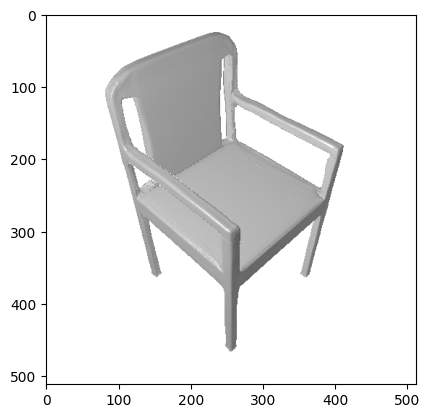

In [34]:
ckpt_path = "/home/borth/sketch2shape/logs/save/train_chairs/checkpoints/last.ckpt"
sdf = SDF(ckpt_path=ckpt_path, obj_idx=34)
camera = Camera(azim=-45, elev=45, resolution=512, dist=1.2, device=sdf.device)
light = PhongLight(position=[1, 1, 0], device=sdf.device)
points, surface_mask, void_mask = sphere_tracing(
    points=camera.image_plane,
    rays=camera.rays,
    sdf=sdf,
)
normals = normal(sdf, points, surface_mask)
rendered_image = light.image(normals, camera, surface_mask)
plt.imshow(rendered_image.detach().cpu().numpy())